# Implementing a reparameterized Beta sampler
@fritzo 2017-11-30

This notebook derives the `beta_grad(x,alpha,beta)` function that is used to compute reparameterized gradients in `torch.distributions.Beta().sample()`. This is an alternative to the naive stochastic reparameterized gradient estimator based on `Gamma().sample()` gradients.

In [1]:
import os
import torch
from torch.autograd import Variable
import itertools
import numbers
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
from matplotlib import pyplot
from torch.distributions import Beta, Normal
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

def expand_all(*args):
    zero = np.zeros(np.broadcast(*args).shape)
    return tuple(zero + arg for arg in args)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha,beta). This is based on the following definition. Let $x\sim Beta(\alpha,\beta)$ be a Beta random variable. The the reparameterized gradient wrt $\alpha$ is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [3]:
def dx_dalpha(x, alpha, beta):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.beta.cdf
    pdf = scipy.stats.beta.pdf
    if isinstance(alpha, numbers.Number):
        alpha = np.array([alpha])
    eps = 0.01 * alpha / (1.0 + np.sqrt(alpha))
    d_dalpha = (cdf(x, alpha + eps, beta) - cdf(x, alpha - eps, beta)) / (2 * eps)
    d_dx = pdf(x, alpha, beta)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

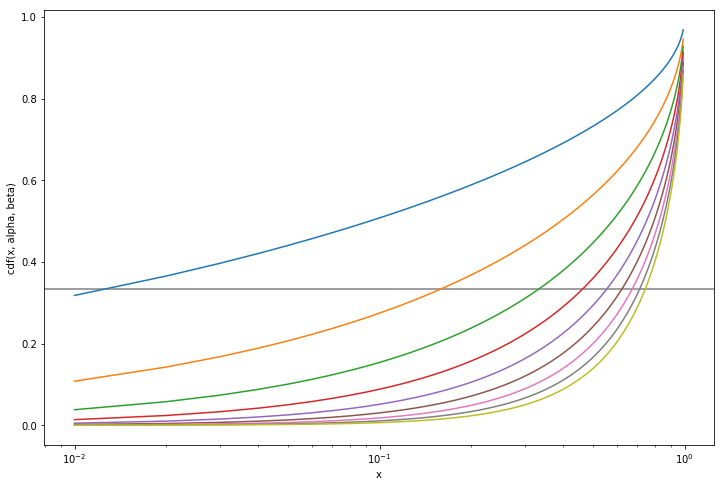

In [4]:
x = np.arange(0, 1, 0.01)
pyplot.figure(figsize=(12,8)).patch.set_facecolor('white')
pyplot.axhline(0.333, color='gray')
beta = 0.5
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(x, scipy.stats.beta.cdf(x, alpha, beta))
pyplot.xscale('log')
pyplot.xlabel('x')
pyplot.ylabel('cdf(x, alpha, beta)')
pyplot.show()

In [5]:
digamma = scipy.special.digamma

def dx_dalpha_small_v1(x, alpha, beta):
    return x / alpha * (1.0 / alpha + digamma(alpha) - digamma(alpha + beta) - np.log(x))
def dx_dalpha_small_v2(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2)
    beta_cdf_alpha = (np.log(x) + digamma(alpha+beta) - digamma(alpha)) * beta_cdf \
        + x**alpha * (-1/alpha**2 + (beta-1)/(alpha+1)**2*x
                                  - (beta-1)*(beta-2)/(alpha+2)**2*x**2/2)
    return -beta_cdf_alpha / beta_pdf
def dx_dalpha_small_v3(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2
                                   - (beta-1)*(beta-2)*(beta-3)/(alpha+3)*x**3/6)
    beta_cdf_alpha = (np.log(x) + digamma(alpha+beta) - digamma(alpha)) * beta_cdf \
        + x**alpha * (-1/alpha**2 + (beta-1)/(alpha+1)**2*x
                                  - (beta-1)*(beta-2)/(alpha+2)**2*x**2/2
                                  + (beta-1)*(beta-2)*(beta-3)/(alpha+3)**2*x**3/6)
    return -beta_cdf_alpha / beta_pdf
def dx_dalpha_small_v4(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2
                                   - (beta-1)*(beta-2)*(beta-3)/(alpha+3)*x**3/6
                                   + (beta-1)*(beta-2)*(beta-3)*(beta-4)/(alpha+4)*x**4/24)
    beta_cdf_alpha = (np.log(x) + digamma(alpha+beta) - digamma(alpha)) * beta_cdf \
        + x**alpha * (-1/alpha**2 + (beta-1)/(alpha+1)**2*x
                                  - (beta-1)*(beta-2)/(alpha+2)**2*x**2/2
                                  + (beta-1)*(beta-2)*(beta-3)/(alpha+3)**2*x**3/6
                                  - (beta-1)*(beta-2)*(beta-3)*(beta-4)/(alpha+4)**2*x**4/24)
    return -beta_cdf_alpha / beta_pdf
def dx_dbeta_small_v1(x, alpha, beta):
    return x / alpha * (digamma(beta) - digamma(alpha + beta))
def dx_dbeta_small_v2(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2)
    beta_cdf_beta = (digamma(alpha+beta) - digamma(beta)) * beta_cdf \
        + x**alpha * (0 - 1/(alpha+1)*x
                        + (2*beta-3)/(alpha+2)*x**2/2)
    return -beta_cdf_beta / beta_pdf
def dx_dbeta_small_v3(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2
                                   - (beta-1)*(beta-2)*(beta-3)/(alpha+3)*x**3/6
                                   + (beta-1)*(beta-2)*(beta-3)*(beta-4)/(alpha+4)*x**4/24)
    beta_cdf_beta = (digamma(alpha+beta) - digamma(beta)) * beta_cdf \
        + x**alpha * (0 - 1/(alpha+1)*x
                        + (2*beta-3)/(alpha+2)*x**2/2
                        - (3*beta**2-12*beta+11)/(alpha+3)*x**3/6
                        + (4*beta**3-30*beta**2+70*beta-50)/(alpha+4)*x**4/24)
    return -beta_cdf_beta / beta_pdf
def dx_dbeta_small_v4(x, alpha, beta):
    beta_pdf = x**(alpha-1) * (1-x)**(beta-1)
    beta_cdf = x**alpha * (1/alpha - (beta-1)/(alpha+1)*x
                                   + (beta-1)*(beta-2)/(alpha+2)*x**2/2
                                   - (beta-1)*(beta-2)*(beta-3)/(alpha+3)*x**3/6
                                   + (beta-1)*(beta-2)*(beta-3)*(beta-4)/(alpha+4)*x**4/24
                                   - (beta-1)*(beta-2)*(beta-3)*(beta-4)*(beta-5)/(alpha+5)*x**5/120)
    beta_cdf_beta = (digamma(alpha+beta) - digamma(beta)) * beta_cdf \
        + x**alpha * (0 - 1/(alpha+1)*x
                        + (2*beta-3)/(alpha+2)*x**2/2
                        - (3*beta**2-12*beta+11)/(alpha+3)*x**3/6
                        + (4*beta**3-30*beta**2+70*beta-50)/(alpha+4)*x**4/24
                        - (274-450*beta+255*beta**2-60*beta**3+5*beta**4)/(alpha+5)*x**5/120)
    return -beta_cdf_beta / beta_pdf
def dx_dalpha_small_valid(x, alpha, beta):
    return x * (1.0 + alpha + beta) < 0.85     ### revisit this boundary ###
dx_dalpha_small = dx_dalpha_small_v4

def dx_dalpha_large_v1(x, alpha, beta):
    # Equivalent to:
    # return -dx_dbeta_small(1.0 - x, beta, alpha)
    total = alpha + beta
    return (digamma(total) - digamma(alpha)) * (1-x) / beta
def dx_dalpha_large_v2(x, alpha, beta):
    return -dx_dbeta_small_v2(1-x, beta, alpha)
def dx_dalpha_large_v3(x, alpha, beta):
    return -dx_dbeta_small_v3(1-x, beta, alpha)
def dx_dalpha_large_v4(x, alpha, beta):
    return -dx_dbeta_small_v4(1-x, beta, alpha)
def dx_dalpha_large_valid(x, alpha, beta):
    #### move the boundary from 0.5 to 0.7. probably ok?
    return (1-x) * (1.0 + alpha + beta) < 0.7
dx_dalpha_large = dx_dalpha_large_v4

# Rice expansion
def dx_dalpha_mid(x, alpha, beta):
    total = alpha+beta
    mean = alpha/total    
    std = np.sqrt(alpha*beta/(total+1))/total
    delta = 0.1*std # size of region we remove around singularity
    plusminus = np.piecewise(x, [x < mean, x > mean], [1, -1])
    
    # for x far from mean
    far_prefactor=x*(x-1)/np.sqrt(2*alpha*beta/total)
    stirling=(1+1/(12*alpha)+1/(288*alpha**2))*(1+1/(12*beta)+1/(288*beta**2))/(1+1/(12*total)+1/(288*total**2))
    term1_num=2*alpha**2*(-1+x)+alpha*beta*(x-1)-x*beta**2
    term1_den=np.sqrt(2*alpha/beta)*np.power(total,1.5)*(alpha*(x-1)+beta*x)**2
    term1=term1_num/term1_den
    term2=0.5*np.log(alpha/(total*x))
    term3_num=np.sqrt(8*alpha*beta/total)
    term3_den=beta*x+alpha*(x-1)
    term3=term3_num/term3_den   
    term4_base=beta*np.log(beta/(total*(1-x))) + alpha*np.log(alpha/(total*x))
    term4=np.power(term4_base,-1.5)
    term1234 = term1+term2*(term3+plusminus*term4)
    result_far = stirling*far_prefactor*term1234
    removable = np.piecewise(x, [np.abs(x - mean)<delta, np.abs(x - mean)>=delta], [1, 0])    
    
    # for x near mean
    near_xpoly = alpha**3*beta*(453+1620*beta*(1-x)-455*x)
    near_xpoly += 3*alpha**2*beta**2 * (59+180*beta-90*x)
    near_xpoly += 8*alpha**4*(1-x)*(135*beta-11)
    near_xpoly += 47*beta**4*x + alpha*beta**3*(43+20*(16+27*beta)*x)
    prefactor_near_num = (1 + 12*alpha)*(1 + 12*beta)
    prefactor_near_den = 12960*total**2*alpha**3*beta**2*(1 + 12*total) 
    result_near = prefactor_near_num*near_xpoly/prefactor_near_den
    
    return (1-removable)*result_far + removable*result_near

def dx_dalpha_mid_valid(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    mask = (alpha >= 6) & (beta >= 6)   # could imagine these 8s being in the 5-10 range
    return mask

In [6]:
LB, UB = 1e-4, 1e3
alphas = LB * (UB / LB) ** np.random.random(100000)
betas = LB * (UB / LB) ** np.random.random(100000)
xs = scipy.stats.beta.rvs(alphas, betas)
truth = dx_dalpha(xs, alphas, betas)
approximations = [
    ('small1', dx_dalpha_small_v1, dx_dalpha_small_valid),
    ('small2', dx_dalpha_small_v2, dx_dalpha_small_valid),
    ('small3', dx_dalpha_small_v3, dx_dalpha_small_valid),
    ('small4', dx_dalpha_small_v4, dx_dalpha_small_valid),
    ('large1', dx_dalpha_large_v1, dx_dalpha_large_valid),
    ('large2', dx_dalpha_large_v2, dx_dalpha_large_valid),
    ('large3', dx_dalpha_large_v3, dx_dalpha_large_valid),
    ('large4', dx_dalpha_large_v4, dx_dalpha_large_valid),    
    ('mid', dx_dalpha_mid, dx_dalpha_mid_valid),
]
print('\t'.join(['version', 'max_err', 'rms_err',
                 'alpha', 'beta', 'x', 'truth', 'approx', 'volume']))
print('-' * 9 * 8)
for name, approx_fn, is_valid in approximations:
    w = is_valid(xs, alphas, betas) & (truth > 0)
    approx = approx_fn(xs[w], alphas[w], betas[w])
    error = np.abs(approx - truth[w]) / (1e-8 + truth[w])
    ### sometimes this is a more useful notion of error
    ## look at both! (the error when the gradients approach zero is basically wrong. all expansions
    ## seem to get those limits right)
    #error = np.abs(approx - truth[w]) / (np.abs(truth[w])+np.abs(approx))
    i = np.argmax(error)
    print('{}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}\t{:0.2g}'.format(
        name, error.max(), (error**2).mean()**0.5,
        alphas[w][i], betas[w][i], xs[w][i], truth[w][i], approx[i], w.mean()))

version	max_err	rms_err	alpha	beta	x	truth	approx	volume
------------------------------------------------------------------------
small1	4.8	0.21	0.0039	0.017	0.83	1.8e+03	1e+04	0.28
small2	0.076	0.0031	0.12	1.7e+02	0.0049	0.03	0.028	0.28
small3	0.021	0.00063	0.018	0.12	0.74	79	81	0.28
small4	0.013	0.00027	0.018	0.12	0.74	79	81	0.28
large1	2.2	0.1	0.0063	0.0056	0.31	2.9e+03	9.2e+03	0.14
large2	0.12	0.0093	2.5e+02	0.00011	1	4.4e-09	6.1e-09	0.14
large3	0.12	0.0014	2.5e+02	0.00011	1	4.4e-09	6.1e-09	0.14
large4	0.12	0.0014	2.5e+02	0.00011	1	4.4e-09	6.1e-09	0.14
mid	0.0017	0.00012	6.9	6.1	0.18	0.037	0.037	0.1


/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:400: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a, b))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power


/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in multiply
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in power


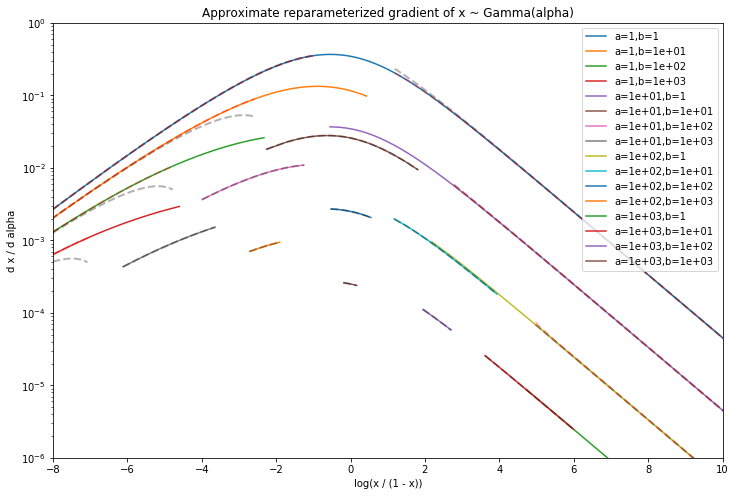

In [7]:
pyplot.figure(figsize=(12, 8)).patch.set_facecolor('white')
grid = [
    #1e-2,
    1e0, 1e1, 1e2, 1e3,
]
for alpha, beta in itertools.product(grid, grid):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)),
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small_v1(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_small_v2(x[w], alpha, beta), 'r--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large_v1(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    pyplot.plot(u[w], dx_dalpha_large_v2(x[w], alpha, beta), 'r--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    if w.any():
        pyplot.plot([np.log(alpha / beta)],
                    [dx_dalpha_mid(alpha / (alpha + beta), alpha, beta)], 'r+')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-8, 10)
pyplot.ylim(1e-6, 1e0)
pyplot.legend()
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  


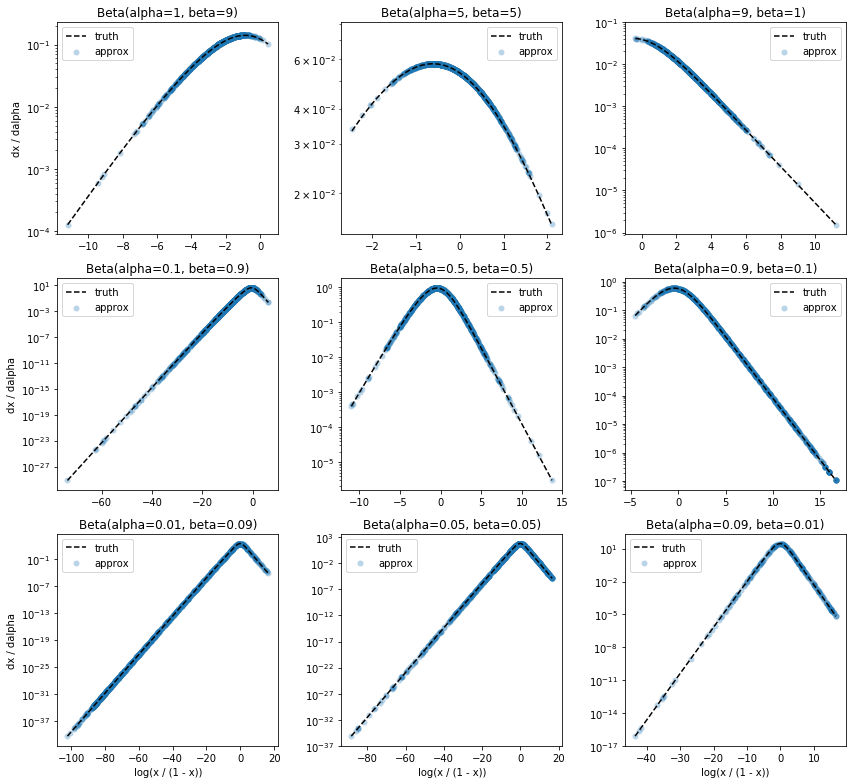

In [8]:
set_seed(0)
fig, axes = pyplot.subplots(3, 3, figsize=(12,11))
fig.patch.set_facecolor('white')
alpha_grid = [1.0, 5.0, 9.0, 0.1, 0.5, 0.9, 0.01, 0.05, 0.09]
beta_grid = [9.0, 5.0, 1.0, 0.9, 0.5, 0.1, 0.09, 0.05, 0.01]
ones = torch.ones(1000)
for i, (ax, alpha, beta) in enumerate(zip(axes.reshape(-1), alpha_grid, beta_grid)):
    alphas = Variable(alpha * ones, requires_grad=True)
    betas = Variable(beta * ones)
    x = Beta(alphas, betas).rsample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    u = np.log(x / (1 - x))
    actual_grad = alphas.grad.data[ind].numpy()
    ax.scatter(u, actual_grad, alpha=0.3, label='approx', lw=0)
    ax.plot(u, dx_dalpha(x, alpha, beta), 'k--', label='truth')
    ax.set_yscale('log')
    ax.set_title('Beta(alpha={:0.1g}, beta={:0.1g})'.format(alpha, beta))
    if i >= 6:
        ax.set_xlabel('log(x / (1 - x))')
    if i % 3 == 0:
        ax.set_ylabel('dx / dalpha')
    ax.legend()
pyplot.tight_layout()
pyplot.savefig(os.path.expanduser('~/Downloads/beta-reparameterized.png'))
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is.

In [9]:
n = 10
dist = Beta(Variable(torch.exp(torch.rand(n * 1000000) * 6 - 3), requires_grad=True),
            Variable(torch.exp(torch.rand(n * 1000000) * 6 - 3), requires_grad=True))
print('---- Forward ----')
%time x = dist.rsample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 1.7 s, sys: 78.2 ms, total: 1.78 s
Wall time: 1.78 s
---- Backward ----
CPU times: user 2.68 s, sys: 126 ms, total: 2.8 s
Wall time: 2.81 s


Here's a Normal distribution for comparison.

In [10]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.rsample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 364 ms, sys: 53.2 ms, total: 417 ms
Wall time: 416 ms
---- Backward ----
CPU times: user 45.7 ms, sys: 18.1 ms, total: 63.8 ms
Wall time: 63.6 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha, beta)` that we want to approximate.

Let's approximate using a trivariate rational function of $\log(x/(1-x))$, $\log(\alpha)$, and $\log(\beta)$. We'll approximate using quadratic $4 x(1-x)$ nonlinearity.

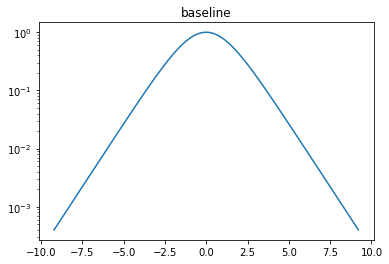

In [11]:
x = np.arange(0.0001, 1.0, 0.0001)
pyplot.plot(np.log(x / (1-x)), 4*x*(1-x))
pyplot.yscale('log')
pyplot.title('baseline')
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/p

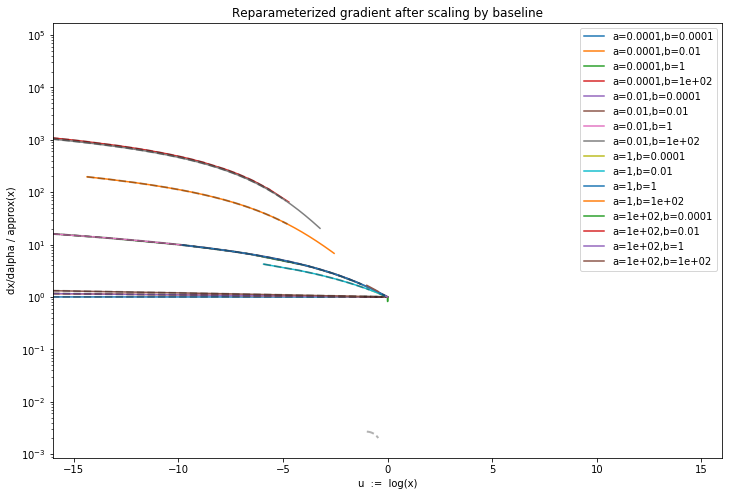

In [12]:
pyplot.figure(figsize=(12, 8)).patch.set_facecolor('white')
for alpha, beta in itertools.product([1e-4, 1e-2, 1e0, 1e2], [1e-4, 1e-2, 1e0, 1e2]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x)
    g0 = x * (1-x) * (digamma(alpha + beta) - digamma(alpha)) / beta
    pyplot.plot(u, dx_dalpha(x, alpha, beta) / g0,
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
pyplot.title('Reparameterized gradient after scaling by baseline')
pyplot.xlabel('u  :=  log(x)')
pyplot.ylabel('dx/dalpha / approx(x)')
pyplot.yscale('log')
pyplot.xlim(-16, 16)
pyplot.legend()
pyplot.show()

This suggests a rational approximation of the center of the plot.

In [13]:
order = (2, 3, 3, 3)
K = order[0] * order[1] * order[2] * order[3]  # number of training parameters
def dx_dalpha_approx(x, alpha, beta, coef):
    x, alpha, beta = expand_all(x, alpha, beta)
    coef = coef.reshape(order).copy()
    coef[1, 0, 0, 0] = 1.0
    u = np.log(x)
    a = np.log(alpha)
    b = np.log(alpha + beta)
    us = [1.0, u, u * u, u * u * u]
    As = [1.0, a, a * a, a * a * a]
    bs = [1.0, b, b * b, b * b * b]
    p = 0.0
    q = 0.0
    for i in range(order[1]):
        for j in range(order[2]):
            for k in range(order[3]):
                p += coef[0][i][j][k] * us[i] * As[j] * bs[k]
                q += coef[1][i][j][k] * us[i] * As[j] * bs[k]
    baseline = x * (1 - x) * (digamma(alpha + beta) - digamma(alpha)) / beta
    return p / np.maximum(1e-3, q) * baseline

### Constructing training data

We construct a stratified training set to balance the non-asymptotic data points among all $(\alpha,\beta)$ pairs.

In [14]:
np.random.seed(sum(order))  # Warm start with different data.
size_train = 12000
LB, UB, grid_size = 1e-3, 1e3, 16
grid = LB * (UB / LB) ** (np.array(range(grid_size)) / (grid_size - 1.0))
alpha_bins, beta_bins, x_bins = [], [], []
bin_size = size_train / len(grid) ** 2
for alpha, beta in itertools.product(grid, grid):
    alpha_train = alpha * np.ones(10 * size_train)
    beta_train = beta * np.ones(10 * size_train)
    x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
    valid = ~(dx_dalpha_small_valid(x_train, alpha_train, beta_train) |
              dx_dalpha_large_valid(x_train, alpha_train, beta_train) |
              dx_dalpha_mid_valid(x_train, alpha_train, beta_train))
    valid = valid.nonzero()[0]
    valid = valid[:bin_size]
    if len(valid) and len(valid) < bin_size:
        print('Warning: only {}/{} samples collected for alpha={:0.2g}, beta={:0.2g}'.format(
        len(valid), bin_size, alpha, beta))
    alpha_bins.append(alpha_train[valid])
    beta_bins.append(beta_train[valid])
    x_bins.append(x_train[valid])

alpha_train = np.concatenate(alpha_bins)
beta_train = np.concatenate(beta_bins)
x_train = np.concatenate(x_bins)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)
print('Data size = {}'.format(len(grad_train)))

Data size = 7729


In [15]:
def approx_objective(coef):
    approx = dx_dalpha_approx(x_train, alpha_train, beta_train, coef).reshape(-1)
    error = 1 - approx / grad_train
    return np.concatenate([error, [1 - coef.reshape(order)[1,0,0,0]]])

We'll warm start higher-order solutions with a low-order solution.

In [16]:
coef0 = np.zeros(K)
coef0.reshape(order)[0,0,0,0] = 1
coef0.reshape(order)[1,0,0,0] = 1

coef2222 = np.array([1.0087932607690575, -0.12306052754060408, -0.085377948135413509, 0.012123313286381254, -0.23686480656973838, -0.1347205852682109, 0.056170022842174601, 0.053186556515628834, 1.0, -0.11233077502781405, -0.098914510320975979, 0.012649896598630887, 0.14600545492491335, -0.0173583865166601, -0.017514769903293634, 0.0022916256830081728])
coef2222 = coef2222.reshape((2, 2, 2, 2))
if all(i <= j for i, j in zip((2, 2, 2, 2), order)):
    coef0.reshape(order)[:2, :2, :2, :2] = coef2222

coef2233 = np.array([0.9858587714759246, -0.17574136140285673, -0.017793999742439635, -0.079915260666635762, 0.031064234251260453, 0.0095185135874287785, 0.034888083500216875, -0.01211378782734507, -0.00019414600546718592, -0.23859595890770019, -0.10091098854055673, 0.0080151285133407465, 0.073699008426536983, 0.034034235461103388, -0.0024028860344216495, 0.0034577428604307642, -0.015371772142007226, 0.0015181589649719939, 0.999999999999998, -0.21596785585536821, 0.011672149929224534, -0.081350425092142159, 0.03237611446264279, -0.0028466878660106574, 0.028440691820375407, -0.0045352697868179517, 0.00010972136064806946, 0.15102898456684799, -0.034821386630565131, 0.0020212675708690887, -0.027325703609025611, 0.009238111968889174, -0.00075381444619305397, 0.0033265296242932386, -0.00044476928456052876, 9.1559419191310505e-09])
coef2233 = coef2233.reshape((2, 2, 3, 3))
if all(i <= j for i, j in zip((2, 2, 3, 3), order)):
    coef0.reshape(order)[:2, :2, :3, :3] = coef2233
    
coef2333 = np.array([0.9998906765509209, -0.18788470988715172, 0.010307024596978876, -0.077718377173631822, 0.038773082397972017, -0.0029086668665538377, 0.043211096874024198, -0.011279350148786883, 0.00095545847823424058, -0.24121833112548377, -0.11484448383233065, 0.026480559908109338, 0.054297208144998561, 0.044044185838426585, -0.016187582132967452, -0.017007441386898914, -0.0035650934128315412, 0.0024223459872254691, -0.013565364779086923, 0.019646402976568889, 0.0027727562830242997, 0.0032877207716096339, -0.011071020412874225, -0.0010944436897898911, -2.5329822163787267e-05, 0.0036245578025676287, -2.2475173727636085e-05, 0.99999999999999722, -0.18967597426139285, 0.013331155401089102, -0.074856425414239133, 0.034774727862516119, -0.0029344272730633951, 0.043799067772418175, -0.011234095841741138, 0.00095647093014738171, 0.15676318528083999, -0.03014699105993119, 0.0023919148846882209, -0.02311725888921843, 0.0094081957212271104, -0.00077765065134543837, 0.0028313731395630329, -0.00098926395974218003, 0.00013637976811461863, 0.012070032279379726, -0.0025629024221997285, 0.00019528760407053704, 0.00085955029999357539, 3.733173944529483e-05, -1.4782484179429326e-05, -5.4436732065033469e-05, -1.3940785298339737e-06, 4.8705106040564278e-06])
coef2333 = coef2333.reshape((2, 3, 3, 3))
if all(i <= j for i, j in zip((2, 3, 3, 3), order)):
    coef0.reshape(order)[:2, :3, :3, :3] = coef2333

In [17]:
soln = scipy.optimize.least_squares(approx_objective, coef0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coef1 = soln.x
print(soln)
print('coeff = {}'.format(list(coef1)))
error = approx_objective(coef1)
i_worst = np.abs(error).argmax()
print('error = {:0.3g} rms, {:0.3g} max at alpha={:0.3g}, beta={:0.3g}, x={:0.3g}'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max(),
    alpha_train[i_worst], beta_train[i_worst], x_train[i_worst]))

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:117: UserWarning: `gtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`gtol`", EPS))


 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])
        cost: 0.067161893355998772
         fun: array([  2.25118941e-03,   2.75496501e-03,   2.95411920e-03, ...,
         1.42687501e-03,   3.71710695e-03,  -2.81996648e-13])
        grad: array([ -1.93700095e-03,  -8.60398243e-03,   5.00474822e-03,
         7.62554420e-03,   7.06090633e-03,  -1.81979323e-04,
        -3.37974807e-05,  -2.61382880e-03,  -1.52075641e-04,
        -8.70276795e-03,   6.47075909e-04,   1.97208151e-03,
        -5.88771969e-03,  -5.17492553e-03,   8.40549418e-04,
        -6.71503007e-03,   4.73903100e-03,   2.92014176e-03,
         1.12684799e-03,  -8.94784253e-03,   3.07502377e-03,
        -3.82345575e-03,  -5.26868913e-03,   7.75061344e-03,
 

Here's a per-region version that's closer our C implementation:

In [18]:
def dx_dalpha_final(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    result = dx_dalpha_approx(x, alpha, beta, coef1)
    w = dx_dalpha_small_valid(x, alpha, beta)
    result[w] = dx_dalpha_small(x[w], alpha[w], beta[w])
    w = dx_dalpha_large_valid(x, alpha, beta)
    result[w] = dx_dalpha_large(x[w], alpha[w], beta[w])
    w = dx_dalpha_mid_valid(x, alpha, beta)
    result[w] = dx_dalpha_mid(x[w], alpha[w], beta[w])
    return result

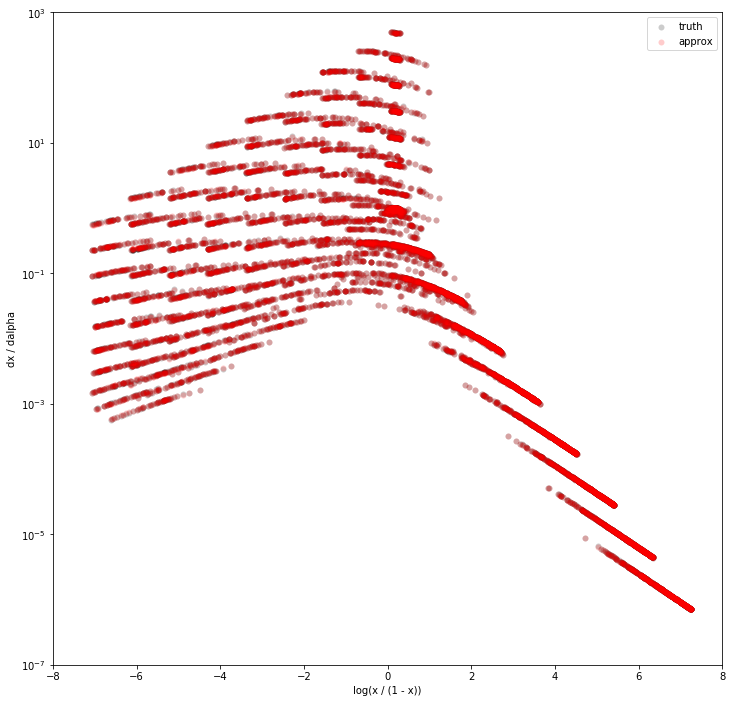

In [19]:
grad_approx = dx_dalpha_final(x_train, alpha_train, beta_train)
u = np.log(x_train / (1 - x_train))
pyplot.figure(figsize=(12, 12)).patch.set_facecolor('white')
pyplot.scatter(u, grad_train, color='black', lw=0, alpha=0.2, label='truth')
pyplot.scatter(u, grad_approx, color='red', lw=0, alpha=0.2, label='approx')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('dx / dalpha')
pyplot.yscale('log')
pyplot.xlim(-8, 8)
pyplot.ylim(1e-7, 1e3)
pyplot.legend()
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in add
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in maximum
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in power
/Users/fritzobermeyer/miniconda2/envs/pytorch-

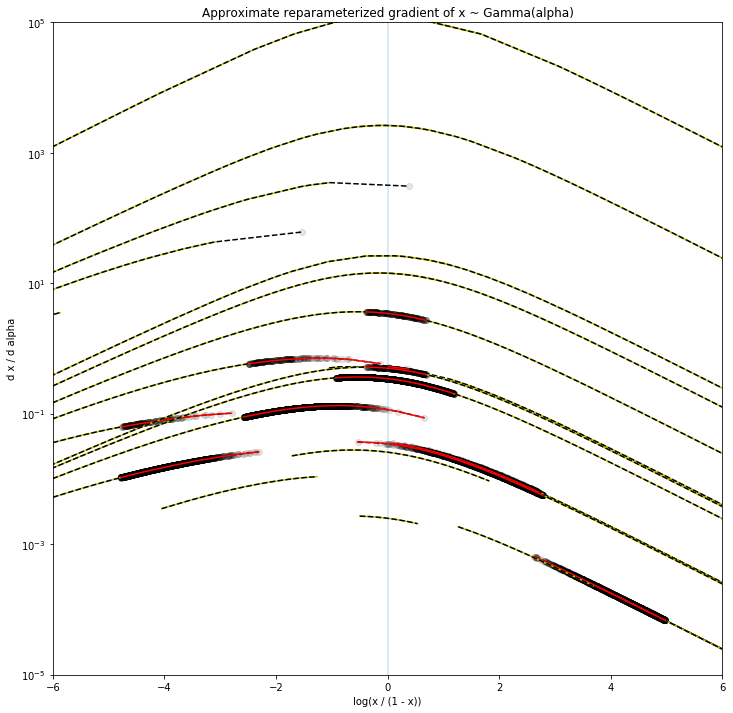

In [20]:
pyplot.figure(figsize=(12, 12)).patch.set_facecolor('white')
ones = np.ones(5000)
grid = [1e-3, 1e-1, 1e0, 1e1, 1e2]
for alpha, beta in itertools.product(grid, grid):
    x = scipy.stats.beta.rvs(ones * alpha, ones * beta)
    x.sort()
    u = np.log(x / (1 - x))
    w1 = dx_dalpha_small_valid(x, alpha, beta)
    w2 = dx_dalpha_large_valid(x, alpha, beta)
    w3 = dx_dalpha_mid_valid(x, alpha, beta)
    w = ~(w1 | w2 | w3)
    pyplot.plot(u[w1], np.maximum(1e-20, dx_dalpha_final(x[w1], alpha, beta)), 'y-')
    pyplot.plot(u[w2], np.maximum(1e-20, dx_dalpha_final(x[w2], alpha, beta)), 'y-')
    pyplot.plot(u[w3], np.maximum(1e-20, dx_dalpha_final(x[w3], alpha, beta)), 'y-')
    pyplot.scatter(u[w], np.maximum(1e-20, dx_dalpha(x[w], alpha, beta)),
                   color='black', alpha=0.1)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), 'k--')
    pyplot.plot(u[w], np.maximum(1e-20, dx_dalpha_final(x[w], alpha, beta)), 'r-')
pyplot.axvline(0, alpha=0.2)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-6, 6)
pyplot.ylim(1e-5, 1e5)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [21]:
I, J, K, L = order
print('static const double c[{}][{}][{}][{}] = {{'.format(*order))
for i, blocks in enumerate(coef1.reshape(order)):
    for j, block in enumerate(blocks):
        for k, row in enumerate(block):
            line = '  '
            line += '{' if j == 0 and k == 0 else ' '
            line += '{' if k == 0 else ' '
            line += '{' + ', '.join(map('{:0.10g}'.format, row)) + '}'
            line += '}' if k == K-1 else ''
            line += '}' if j == J-1 and k == K-1 else ''
            print(line + ',')
print('};')

static const double c[2][3][3][3] = {
  {{{1.000809434, -0.1682354885, 0.008047157506},
    {-0.06924416383, 0.03606983203, -0.00272484835},
    {0.04470002528, -0.01187720048, 0.001038840798}},
   {{-0.2270703405, -0.1242298156, 0.02538574658},
    {0.05391358059, 0.04572258934, -0.01613279386},
    {-0.01764165186, -0.003303205678, 0.002420738474}},
   {{-0.02116387653, 0.01915553496, 0.002623941253},
    {0.00607731048, -0.01176094091, -0.0009988469293},
    {-5.761802475e-05, 0.003675257765, -2.583159583e-05}}},
  {{{1, -0.1670780733, 0.0105236485},
    {-0.06723476699, 0.03146777165, -0.002510525891},
    {0.04534682699, -0.01186879351, 0.001027298003}},
   {{0.1724634113, -0.02714867066, 0.001757764501},
    {-0.02255570842, 0.008817016294, -0.0006756837562},
    {0.003089685571, -0.001143748293, 0.0001564099564}},
   {{0.01456814828, -0.002673828412, 0.0001675973406},
    {0.0004791130966, 0.0001054758289, -1.487056157e-05},
    {-8.729853397e-05, 8.605291804e-08, 5.544558659e-0